<a href="https://colab.research.google.com/github/MaximilianoRamirezN/lecturasIIC3633-2021/blob/main/practicos/Implicit_feedback.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctico librería implicit - ALS y BPR

Clase: IIC3633 Sistemas Recomendadores, PUC Chile

En este práctico vamos a utilizar la biblioteca de Python [implicit](https://implicit.readthedocs.io/en/latest/quickstart.html) para recomendación utilizando ALS y BPR. 


In [1]:
!curl -L -o "u2.base" "https://drive.google.com/uc?export=download&id=1bGweNw7NbOHoJz11v6ld7ymLR8MLvBsA"
!curl -L -o "u2.test" "https://drive.google.com/uc?export=download&id=1f_HwJWC_1HFzgAjKAWKwkuxgjkhkXrVg"
!curl -L -o "u.item" "https://drive.google.com/uc?export=download&id=10YLhxkO2-M_flQtyo9OYV4nT9IvSESuz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    190      0 --:--:--  0:00:02 --:--:--   190
100 1546k  100 1546k    0     0   682k      0  0:00:02  0:00:02 --:--:--  682k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    419      0 --:--:-- --:--:-- --:--:--   418
100  385k  100  385k    0     0   345k      0  0:00:01  0:00:01 --:--:--  345k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    651      0 --:--:-- --:--:-- --:--:--   649
100  230k  100  230k    0     0   294k      0 --:--:-- --:--:-- --:--:--  294k


In [2]:
!pip3 install implicit --upgrade

     |████████████████████████████████| 1.1 MB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for implicit: filename=implicit-0.4.8-cp37-cp37m-linux_x86_64.whl size=4503516 sha256=2f5eaca1c466841b30aba5b39ca42f7a13da41cc33d974090e62012f7447ec35
  Stored in directory: /root/.cache/pip/wheels/88/e6/34/25e73cccbaf1a961154bb562a5f86123b68fdbf40e306073d6
Successfully built implicit


In [3]:
import pandas as pd
import numpy as np
import implicit
import scipy.sparse as sparse

In [4]:
columns = ['movieid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [5]:
# Primero creamos el dataframe con los datos
df_train = pd.read_csv('u2.base',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)

# rating >= 3 , relevante (1) y rating menor a 3 es no relevante (0)
df_train.rating = [1 if x >=3 else 0 for x in df_train.rating ]

In [6]:
df_train.head()

,userid,itemid,rating,timestamp
0,1,3,1,878542960
1,1,4,1,876893119
2,1,5,1,889751712
3,1,6,1,887431973
4,1,7,1,875071561


In [7]:
# Cargamos el dataset con los items
df_items = pd.read_csv('u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None, 
                        encoding='latin-1')

In [8]:
df_items.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [9]:
# Cargamos el dataset de testing
df_test = pd.read_csv('u2.test',
                      sep='\t',
                      names=['userid', 'itemid', 'rating', 'timestamp'],
                      header=None)


# rating >= 3 es relevante (1) y rating menor a 3 es no relevante (0) 
df_test.rating = [1 if x >=3 else 0 for x in df_test.rating ]


user_items_test = {}

for row in df_test.itertuples():
    if row[1] not in user_items_test:
        user_items_test[row[1]] = []
        
    user_items_test[row[1]].append(row[2])

In [10]:
df_test.head()

,userid,itemid,rating,timestamp
0,1,1,1,874965758
1,1,2,1,876893171
2,1,8,0,875072484
3,1,9,1,878543541
4,1,21,0,878542772


### Métricas

In [11]:
# Definicion de métricas (No editar)
# Obtenido de https://gist.github.com/bwhite/3726239

def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])
  
def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.


def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)

    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

### Preprocesamiento de los datos a formato sparse

In [12]:
user_items = {}
itemset = set()

for row in df_train.itertuples():
    if row[1] not in user_items:
        user_items[row[1]] = []
        
    user_items[row[1]].append(row[2])
    itemset.add(row[2])

itemset = np.sort(list(itemset))

sparse_matrix = np.zeros((len(user_items), len(itemset)))

for i, items in enumerate(user_items.values()):
    sparse_matrix[i] = np.isin(itemset, items, assume_unique=True).astype(int)
    
matrix = sparse.csr_matrix(sparse_matrix.T)

user_ids = {key: i for i, key in enumerate(user_items.keys())}
user_item_matrix = matrix.T.tocsr()

In [13]:
def evaluate_model(model, n):
  mean_map = 0.
  mean_ndcg = 0.
  for u in user_items_test.keys():
    rec = [t[0] for t in model.recommend(u, user_item_matrix, n)]
    rel_vector = [np.isin(user_items_test[u], rec, assume_unique=True).astype(int)]
    mean_map += mean_average_precision(rel_vector)
    mean_ndcg += ndcg_at_k(rel_vector, n)

  mean_map /= len(user_items_test)
  mean_ndcg /= len(user_items_test)
  
  return mean_map, mean_ndcg

In [14]:
def show_recommendations(model, user, n):
  recommendations = [t[0] for t in model.recommend(user, user_item_matrix, n)]
  return df_items.loc[recommendations]['title']

In [15]:
def show_similar_movies(model, item, n=10):
  sim_items = [t[0] for t in model.similar_items(item, n)]
  return df_items.loc[sim_items]['title']

## ALS (Implicit Feedback)

**Pregunta 1:** Explique brevemente cómo funciona el algoritmo ALS.

**Respuesta:** funciona fijando de forma alternada $p_u$ y $q_i$ en la función de pérdida dada por $$\sum_{u,i \in K}(r_{ui} - q_{i}^{t}p_u)^2 - \lambda(||q_i||+||p_u||))$$ Pues de esta forma, es posible ver el problema como un problema convexo cuadrático.

In [16]:
# Definimos y entrenamos el modelo con optimización ALS
model_als = implicit.als.AlternatingLeastSquares(factors=100, iterations=10, use_gpu=False)
model_als.fit(matrix)

  0%|          | 0/10 [00:00<?, ?it/s]

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

In [17]:
show_recommendations(model_als, user=77, n=10)

movieid
256    When the Cats Away (Chacun cherche son chat) (...
754                                    Red Corner (1997)
273                                          Heat (1995)
125                                    Phenomenon (1996)
292                                      Rosewood (1997)
136                  Mr. Smith Goes to Washington (1939)
257                                  Men in Black (1997)
813                         Celluloid Closet, The (1995)
864                           My Fellow Americans (1996)
49                                           I.Q. (1994)
Name: title, dtype: object

In [18]:
maprec, ndcg = evaluate_model(model_als, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.06415829959170337
ndcg: 0.33690658499234305


**Pregunta 2:** Pruebe distintos valores para los parámetros de ALS y muestre gráficos de cómo se ven afectadas las métricas recién mostradas.

## Variando Factors

In [22]:
import matplotlib.pyplot as plt

In [20]:
factors = [50, 100, 150, 200]
map_values = []
ndcg_values = []

for fact in factors:
  # Definimos y entrenamos el modelo con optimización ALS
  model_als = implicit.als.AlternatingLeastSquares(factors=fact, iterations=10, use_gpu=False)
  model_als.fit(matrix)

  maprec, ndcg = evaluate_model(model_als, n=10)

  map_values.append(maprec)
  ndcg_values.append(ndcg)

print("MAP@10: ", map_values)
print("nDCG@k: ", ndcg_values)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

MAP@10:  [0.059907910188979084, 0.0604833900931747, 0.048725759785029965, 0.044311924342675585]
nDCG@k:  [0.30321592649310875, 0.332312404287902, 0.30474732006125577, 0.29709035222052066]


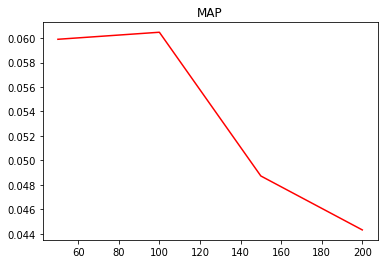

In [23]:
plt.plot(factors, map_values, 'r-')
plt.title("MAP")
plt.show()

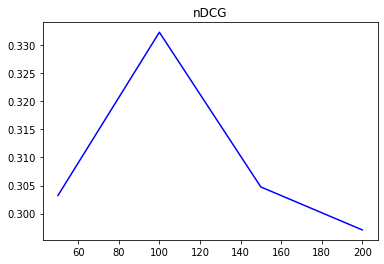

In [25]:
plt.plot(factors, ndcg_values, 'b-')
plt.title("nDCG")
plt.show()

## Variando iteraciones

In [26]:
iteration = [10, 20, 50, 100]
map_values = []
ndcg_values = []

for iter in iteration:
  # Definimos y entrenamos el modelo con optimización ALS
  model_als = implicit.als.AlternatingLeastSquares(factors=100, iterations=iter, use_gpu=False)
  model_als.fit(matrix)

  maprec, ndcg = evaluate_model(model_als, n=10)

  map_values.append(maprec)
  ndcg_values.append(ndcg)

print("MAP@10: ", map_values)
print("nDCG@k: ", ndcg_values)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

MAP@10:  [0.06525715563153024, 0.0702497443357765, 0.0652314605851556, 0.06245509373383964]
nDCG@k:  [0.34150076569678406, 0.3430321592649311, 0.34915773353751917, 0.33690658499234305]


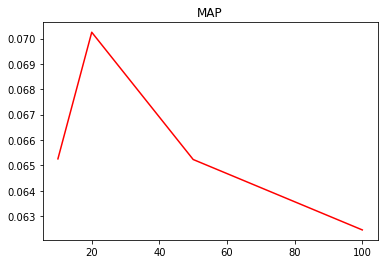

In [29]:
plt.plot(iteration, map_values, 'r-')
plt.title("MAP")
plt.show()

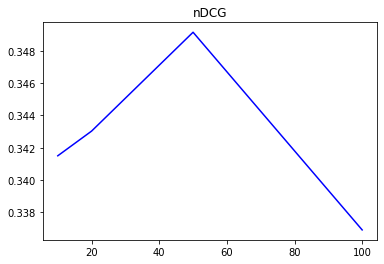

In [30]:
plt.plot(iteration, ndcg_values, 'b-')
plt.title("nDCG")
plt.show()

## BPR

**Pregunta 3:** Explique con sus palabras la intuición del framework BPR.

Intenta aprender la distribución de los datos, para estimar la calificaciones basado en la regla de bayes

In [31]:
# Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=400, iterations=40, use_gpu=False)
model_bpr.fit(matrix)

  0%|          | 0/40 [00:00<?, ?it/s]

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

In [32]:
show_recommendations(model_bpr, user=77, n=10)

movieid
285                          Secrets & Lies (1996)
299                                 Hoodlum (1997)
257                            Men in Black (1997)
301                                In & Out (1997)
327                                Cop Land (1997)
332                          Kiss the Girls (1997)
746                             Real Genius (1985)
331                               Edge, The (1997)
306    Mrs. Brown (Her Majesty, Mrs. Brown) (1997)
300                           Air Force One (1997)
Name: title, dtype: object

In [33]:
show_similar_movies(model_bpr, item=171, n=10)

movieid
171              Delicatessen (1991)
209        This Is Spinal Tap (1984)
203                Unforgiven (1992)
27                   Bad Boys (1995)
175                    Brazil (1985)
78                 Free Willy (1993)
21     Muppet Treasure Island (1996)
201              Evil Dead II (1987)
264                     Mimic (1997)
95                    Aladdin (1992)
Name: title, dtype: object

In [34]:
maprec, ndcg = evaluate_model(model_bpr, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.05162570231373451
ndcg: 0.35222052067381315


**Pregunta 4:** Pruebe distintos valores para los parámetros de BPR y muestre gráficos de cómo se ven afectadas las métricas de ranking (nDCG@10 y MAP) recién mostradas.

## Variando Factors

In [35]:
factors = [50, 100, 150, 200]
map_values = []
ndcg_values = []

for fact in factors:
  # Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
  model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=400, iterations=40, use_gpu=False)
  model_bpr.fit(matrix)

  maprec, ndcg = evaluate_model(model_bpr, n=10)

  map_values.append(maprec)
  ndcg_values.append(ndcg)

print("MAP@10: ", map_values)
print("nDCG@k: ", ndcg_values)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

MAP@10:  [0.04405704528701669, 0.04557501325517389, 0.057104387500038406, 0.0599401605741523]
nDCG@k:  [0.32465543644716693, 0.3430321592649311, 0.34762633996937214, 0.3675344563552833]


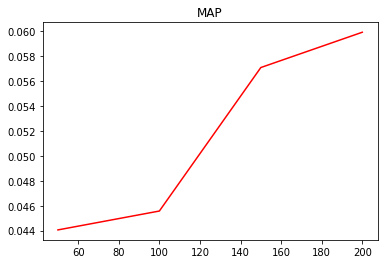

In [36]:
plt.plot(factors, map_values, 'r-')
plt.title("MAP")
plt.show()

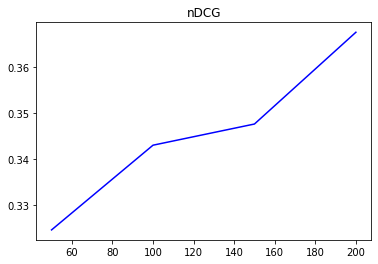

In [37]:
plt.plot(factors, ndcg_values, 'b-')
plt.title("nDCG")
plt.show()

## Variando iteraciones

In [38]:
iteration = [10, 20, 50, 100]
map_values = []
ndcg_values = []

for iter in iteration:
  # Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
  model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=400, iterations=40, use_gpu=False)
  model_bpr.fit(matrix)

  maprec, ndcg = evaluate_model(model_bpr, n=10)

  map_values.append(maprec)
  ndcg_values.append(ndcg)

print("MAP@10: ", map_values)
print("nDCG@k: ", ndcg_values)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

MAP@10:  [0.05337590145049841, 0.049366821516367704, 0.053699380482127385, 0.0576756050213994]
nDCG@k:  [0.35068912710566613, 0.35068912710566613, 0.33690658499234305, 0.35222052067381315]


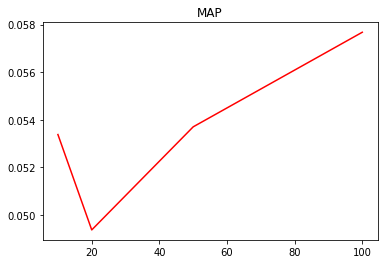

In [39]:
plt.plot(iteration, map_values, 'r-')
plt.title("MAP")
plt.show()

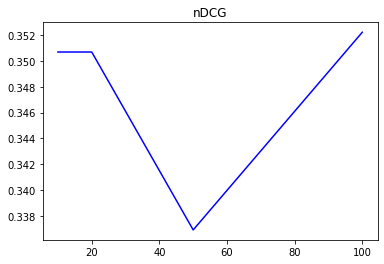

In [40]:
plt.plot(iteration, ndcg_values, 'b-')
plt.title("nDCG")
plt.show()